In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

import matplotlib.pyplot as plt
from IPython.display import clear_output

import sys
sys.path.insert(0,'..')

import sampler
import camera
import optimization
from sdf import DeepSDF, SphereSDF



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cam = camera.PerspectiveCamera()
sdf = SphereSDF(torch.zeros((3), device=device), 1)

# create samples
uv = sampler.grid_2d(64, 64).to(device).unsqueeze(0)
depth = torch.zeros((*uv.shape[:-1], 1), device=uv.device).requires_grad_(True)
pose = torch.zeros((4,4), device=uv.device)
pose[:3, :3] = torch.eye(3)
pose[2,3] = -3

foo = lambda d: sdf(cam(uv, d, pose))

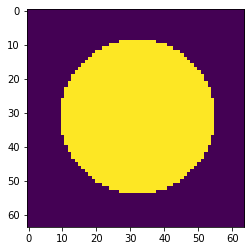

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    
    clear_output(wait=True)
    plt.imshow(foo(depth).detach().cpu().numpy().reshape(64,64,1) < 1e-6)
    #plt.imshow(depth.detach().numpy().reshape(64,64,1))
    plt.show()
    
    depth = optimization.lm(depth, foo, 1e-4)
    
mask_gt = torch.sigmoid(- foo(depth) / 1e-3).view(64,64,1).detach()

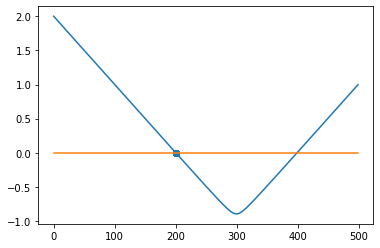

In [4]:
li = []
li2 = []
li3 = []

for i in range(500):
    li.append(foo(torch.ones(*uv.shape[:-1], 1, device=uv.device) * 1e-2 * i)[0, 30*64+30, 0])

for i in range(20):
    depth = optimization.lm(depth, foo)
    ff = foo(depth)
    
    li2.append(depth[0, 30*64+30, 0].item() * 100)
    li3.append(ff[0, 30*64+30, 0].item())
    
plt.plot(range(500), li)
plt.plot(range(500), [0]*500)
plt.scatter(li2, li3)

In [25]:
cam = camera.PerspectiveCamera()

sdf = DeepSDF(8).to(device)
sdf.eval()

DeepSDF(
  (fc0): Linear(in_features=259, out_features=512, bias=True)
  (bn0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=512, out_features=253, bias=True)
  (bn3): LayerNorm((253,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (bn4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (bn5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc6): Linear(in_features=512, out_features=512, bias=True)
  (bn6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc7): Linear(in_features=512, out_features=1, bias=True)
  (bn7): LayerNorm((1,), eps=1e-05, elementwise_affine=T

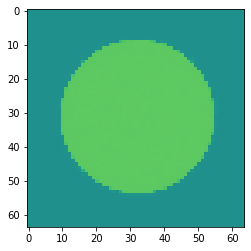

In [26]:
adam = Adam(sdf.parameters(), lr=5e-4)
li = []
for j in range(500):
    # create samples
    uv = sampler.grid_2d(64, 64).to(device).unsqueeze(0)
    depth = torch.zeros((*uv.shape[:-1], 1), device=uv.device).requires_grad_(True)
    pose = torch.zeros((4,4), device=uv.device)
    pose[:3, :3] = torch.eye(3)
    pose[2,3] = -3
    
    foo = lambda d: sdf(torch.cat([cam(uv, d, pose), torch.zeros(*uv.shape[:-1], 256, device=uv.device)], dim=-1))
    
    for i in range(5):
        depth = optimization.lm(depth, foo, 1e-3)
        
    mask = torch.sigmoid(- foo(depth) / 1e-3).view(64,64,1)
    
    clear_output(wait=True)
    
    #plt.imshow((mask - mask_gt).detach().numpy())
    plt.imshow(mask.detach().cpu().numpy())
    plt.clim(-1,1)
    plt.show()

    adam.zero_grad()
    
    loss = ((mask - mask_gt) ** 2).mean()    # l2 loss
    #loss_f = nn.BCELoss()
    #loss = loss_f(mask, mask_gt)              # bce loss
    
    li.append(loss.item())
    loss.backward()
    adam.step()


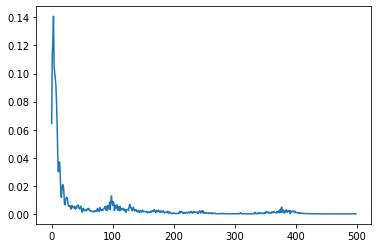

In [27]:
plt.plot(range(500), li)